In [1]:
import rmm

rmm.reinitialize(pool_allocator=True,initial_pool_size=5e+9, maximum_pool_size=20e+9)

In [1]:
import cudf
import cugraph
from cugraph.experimental import PropertyGraph

In [2]:
import cugraph
import cudf
from ogb.nodeproppred import NodePropPredDataset

dataset = NodePropPredDataset(name = 'ogbn-mag', root='/work/dataset/') 

data = dataset[0]

edgelist = cudf.DataFrame()
for elt in list(data[0]['edge_index_dict'].values()):
    elt_df = cudf.DataFrame({
        'src': cudf.from_dlpack(elt[0].__dlpack__()),
        'dst': cudf.from_dlpack(elt[1].__dlpack__())
    })
    edgelist = cudf.concat([edgelist, elt_df])
edgelist['weight']=1.

sg = cugraph.Graph()
sg.from_cudf_edgelist(edgelist, source='src', destination='dst', edge_attr='weight', legacy_renum_only=True)

In [3]:
def exec_gpu_cugraph(batch, fanout):
    cugraph.uniform_neighbor_sample(sg, batch, [fanout,fanout], True)

In [4]:
from datetime import datetime
import numpy as np
import cupy
from time import sleep

batch_size = 1000
tries = 10

res_cugraph = np.empty(99)

for i, fanout in enumerate(range(1,100)):
    batch = cudf.Series(cupy.random.randint(low=0, high=sg.number_of_vertices(), size=batch_size))
    start_time = datetime.now()
    for _ in range(tries):
        exec_gpu_cugraph(batch, fanout)
    end_time = datetime.now()
    sleep(0.01)
    total_time = (end_time - start_time).total_seconds() / tries
    res_cugraph[i] = total_time

In [5]:
import torch
from torch_geometric.data import Data

data = Data(
    edge_index=torch.stack([
        torch.from_dlpack(sg.edgelist.edgelist_df.dst.to_dlpack()),
        torch.from_dlpack(sg.edgelist.edgelist_df.src.to_dlpack())
    ]),
    num_nodes=sg.number_of_vertices()
)

In [6]:
import torch
from torch_geometric.loader.utils import to_csc
sample_fn = torch.ops.torch_sparse.neighbor_sample

out = to_csc(data, device='cpu', share_memory=False,
                is_sorted=False)
colptr, row, perm = out

def exec_cpu_pyg(batch, fanout):


    sample_fn(
        colptr,
        row,
        batch,
        [fanout, fanout],
        True,
        True,
    )

In [7]:
from datetime import datetime
import numpy as np
from time import sleep

import torch

batch_size = 1000
tries = 10

res_pyg_cpu = np.empty(99)

for i, fanout in enumerate(range(1,100)):
    batch = torch.Tensor(np.random.randint(low=0, high=sg.number_of_vertices(), size=batch_size)).to(torch.long)
    start_time = datetime.now()
    for _ in range(tries):
        exec_cpu_pyg(batch, fanout)
    end_time = datetime.now()
    sleep(0.01)
    total_time = (end_time - start_time).total_seconds() / tries
    res_pyg_cpu[i] = total_time

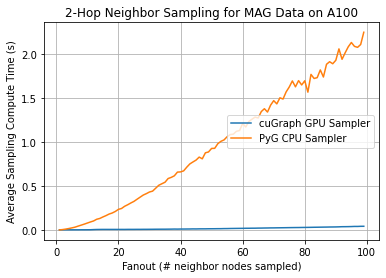

In [8]:
from matplotlib import pyplot as plt
plt.plot(np.array(range(1,100)), res_cugraph, label='cuGraph GPU Sampler')
plt.plot(np.array(range(1,100)), res_pyg_cpu, label='PyG CPU Sampler')
plt.xlabel('Fanout (# neighbor nodes sampled)')
plt.ylabel('Average Sampling Compute Time (s)')
plt.title('2-Hop Neighbor Sampling for MAG Data on A100')
plt.legend(loc='center right')
plt.grid()

In [ ]:
import pandas as pd
df = pd.DataFrame({
    'res_pyg_cpu': res_pyg_cpu,
    'res_cugraph': res_cugraph
})

df.to_csv('./benchmark1.csv')